https://keras.io/examples/vision/involution/

In [26]:
from INN import Involution

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# As the dataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
w,h = 250, 250
batch_size = 16

train_path = 'G:\\Research\\Completed\\ICICT 2024\\xray\\train'
test_path = 'G:\\Research\\Completed\\ICICT 2024\\xray\\test'
val_path = 'G:\\Research\\Completed\\ICICT 2024\\xray\\val'

train_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=0.3
    
)

test_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    # rotation_range=30,            
    # width_shift_range=0.2,        
    # height_shift_range=0.2,       
    # shear_range=0.2,              
    # horizontal_flip=True,         
)

val_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
)

train_dataset = train_img_gen.flow_from_directory(
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory(
    val_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [28]:
unique, counts = np.unique(train_dataset.classes, return_counts=True)
unique_counts = dict(zip(unique, counts))
unique_counts

{0: 460, 1: 1341, 2: 3875, 3: 650}

In [29]:
unique, counts = np.unique(test_dataset.classes, return_counts=True)
unique_counts = dict(zip(unique, counts))
unique_counts

{0: 106, 1: 234, 2: 390, 3: 41}

In [30]:
unique, counts = np.unique(val_dataset.classes, return_counts=True)
unique_counts = dict(zip(unique, counts))
unique_counts

{0: 10, 1: 8, 2: 8, 3: 12}

<Axes: ylabel='count'>

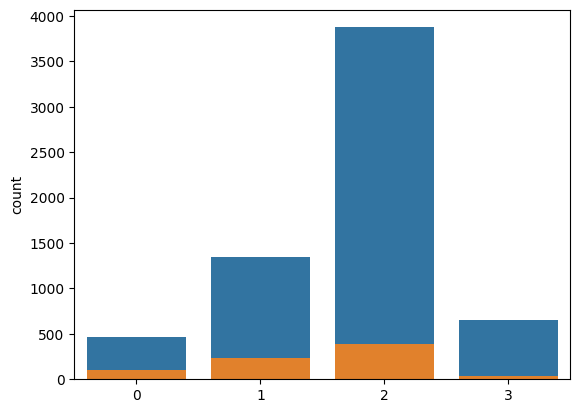

In [31]:
sns.countplot(x = train_dataset.classes)
sns.countplot(x=test_dataset.classes)

In [32]:
# Build the involution model.
import keras.layers


print("building the involution model...")

inputs = keras.Input(shape=(w, h, 3))

# block 1
x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1")(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)

# block 2
x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)

# # block 3
x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)

# # block 4
# x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_4")(x)
# x = keras.layers.ReLU()(x)
# x = keras.layers.MaxPooling2D((2, 2))(x)

# # block 5
# x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_5")(x)
# x = keras.layers.ReLU()(x)
# x = keras.layers.MaxPooling2D((2, 2))(x)



x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(256, activation="relu")(x)


x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(train_dataset.num_classes)(x)

inv_model = keras.Model(inputs=[inputs],
                        outputs=[outputs],
                        name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# inv_model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

inv_model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

inv_model.summary()

building the involution model...
compiling the involution model...
Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 250, 250, 3),     26        
                              (None, 250, 250, 9, 1,             
                             1))                                 
                                                                 
 re_lu_3 (ReLU)              (None, 250, 250, 3)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 125, 125, 3)      0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 125, 125, 3),     2

In [33]:
steps_per_epoch = len(os.listdir(train_path))//8
val_steps_per_epoch = len(os.listdir(val_path))//8

tf.random.set_seed(42)
epoch = 20


# Save best model
weight_path = 'model/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy',
    save_freq='epoch',
    verbose = 1
) 

In [34]:
# train the model
print("inv model training...")

history = inv_model.fit(train_dataset, 
                    epochs=epoch, 
                    validation_data=test_dataset, 
                    callbacks=[model_checkpoint]
                    )

inv model training...
Epoch 1/20
396/396 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.6527
Epoch 1: val_accuracy improved from -inf to 0.64462, saving model to model\
396/396 [==============================] - 94s 233ms/step - loss: 0.8852 - accuracy: 0.6527 - val_loss: 0.7827 - val_accuracy: 0.6446
Epoch 2/20
396/396 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.7684
Epoch 2: val_accuracy improved from 0.64462 to 0.77562, saving model to model\
396/396 [==============================] - 91s 231ms/step - loss: 0.5962 - accuracy: 0.7684 - val_loss: 0.6143 - val_accuracy: 0.7756
Epoch 3/20
396/396 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.8075
Epoch 3: val_accuracy improved from 0.77562 to 0.79767, saving model to model\
396/396 [==============================] - 91s 230ms/step - loss: 0.5185 - accuracy: 0.8075 - val_loss: 0.5579 - val_accuracy: 0.7977
Epoch 4/20
396/396 [==============================] - 

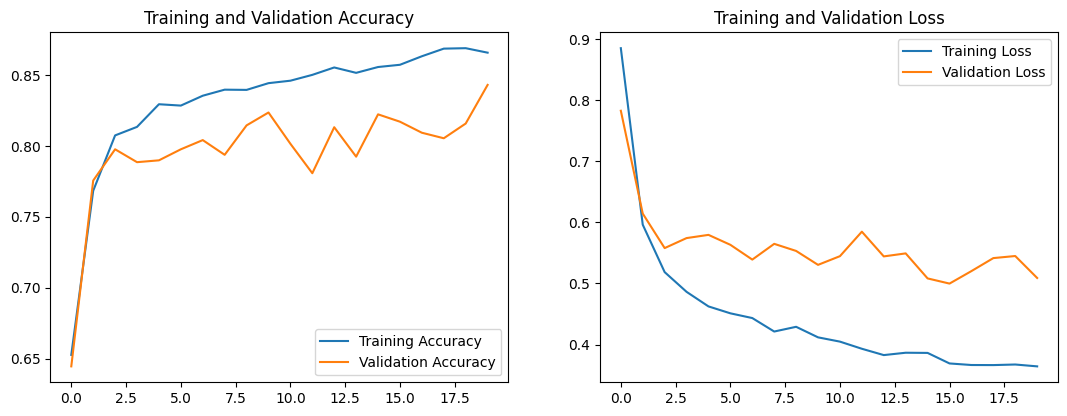

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
labels = ['COVID-19','NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

import numpy as np

# load best weights to model
inv_model.load_weights(weight_path)

# make predictions
predictions = inv_model.predict(test_dataset)
# we have to get the position of the maximum value from each sample.
predicted_class = np.argmax(predictions, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

true_labels = test_dataset.classes

49/49 [==============================] - 6s 117ms/step


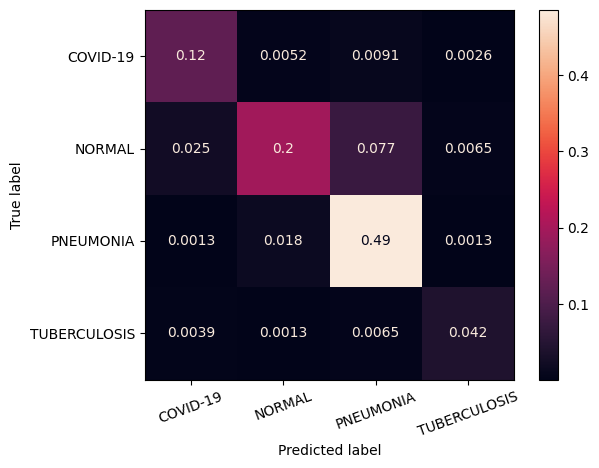

In [52]:
cm = confusion_matrix(true_labels, predicted_class, 
                      normalize='all'
                      )
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='rocket')
plt.xticks(rotation=20)
plt.show()

In [51]:
# Print classification report

class_report = classification_report(true_labels, predicted_class, labels=[0, 1, 2, 3], target_names=labels, digits=4)
print(class_report)

              precision    recall  f1-score   support

    COVID-19     0.8017    0.8774    0.8378       106
      NORMAL     0.8882    0.6453    0.7475       234
   PNEUMONIA     0.8404    0.9590    0.8958       390
TUBERCULOSIS     0.8000    0.7805    0.7901        41

    accuracy                         0.8431       771
   macro avg     0.8326    0.8155    0.8178       771
weighted avg     0.8475    0.8431    0.8372       771



1/1 [==============================] - 0s 178ms/step


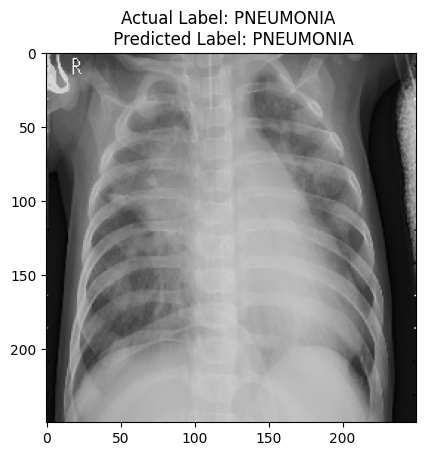

1/1 [==============================] - 0s 26ms/step


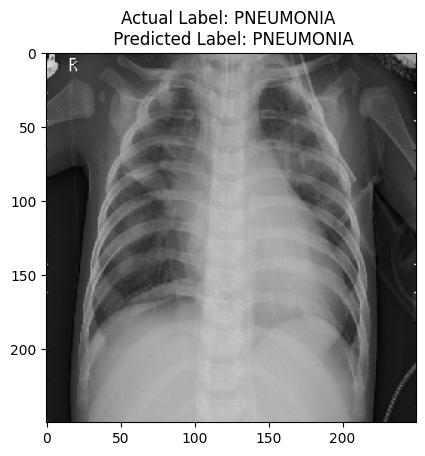

1/1 [==============================] - 0s 25ms/step


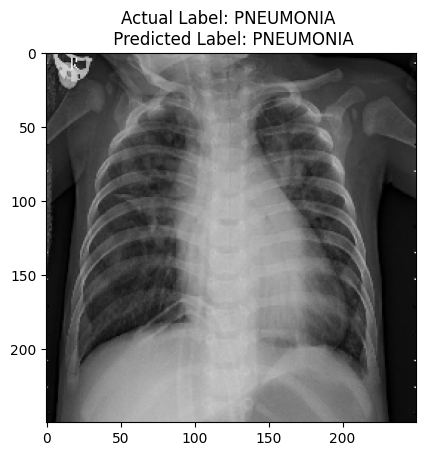

In [39]:
def singlePred(batch, im):


    actual_label = labels[np.argmax(test_dataset.__getitem__(idx=batch)[1][im])]
    pred_label = labels[np.argmax(inv_model.predict(test_dataset.__getitem__(idx=batch)[0])[im])]


    plt.imshow(test_dataset.__getitem__(idx=batch)[0][im])
    plt.title(f"Actual Label: {actual_label} \n Predicted Label: {pred_label}")
    plt.show()
    
for i in range(3):
    singlePred(30,i)

In [40]:
# layer_names = ["inv_1", "inv_2", "inv_3"]
# outputs = [inv_model.get_layer(name).output[1] for name in layer_names]
# vis_model = keras.Model(inv_model.input, outputs)

# fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))

# for ax, test_image in zip(axes, test_images[:10]):
#     (inv1_kernel, inv2_kernel, inv3_kernel) = vis_model.predict(test_image[None, ...])
#     inv1_kernel = tf.reduce_sum(inv1_kernel, axis=[-1, -2, -3])
#     inv2_kernel = tf.reduce_sum(inv2_kernel, axis=[-1, -2, -3])
#     inv3_kernel = tf.reduce_sum(inv3_kernel, axis=[-1, -2, -3])

#     ax[0].imshow(keras.utils.array_to_img(test_image))
#     ax[0].set_title("Input Image")

#     ax[1].imshow(keras.utils.array_to_img(inv1_kernel[0, ..., None]))
#     ax[1].set_title("Involution Kernel 1")

#     ax[2].imshow(keras.utils.array_to_img(inv2_kernel[0, ..., None]))
#     ax[2].set_title("Involution Kernel 2")

#     ax[3].imshow(keras.utils.array_to_img(inv3_kernel[0, ..., None]))
#     ax[3].set_title("Involution Kernel 3")

In [41]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, quickshift

explainer = lime_image.LimeImageExplainer()

Quickshift number of segments: 158


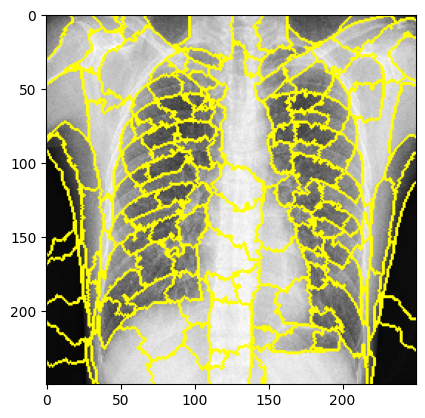

In [42]:
sampleImg = test_dataset.__getitem__(idx=np.random.randint(0,48))[0][np.random.randint(0,16)].astype("double")

segments_quick = quickshift(sampleImg, kernel_size=3, max_dist=8, ratio=0.5)
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

plt.imshow(mark_boundaries(sampleImg, segments_quick))
# plt.title('Quickshift Sample')
plt.show()

batch : 46, sample no: 5
1/1 [==============================] - 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


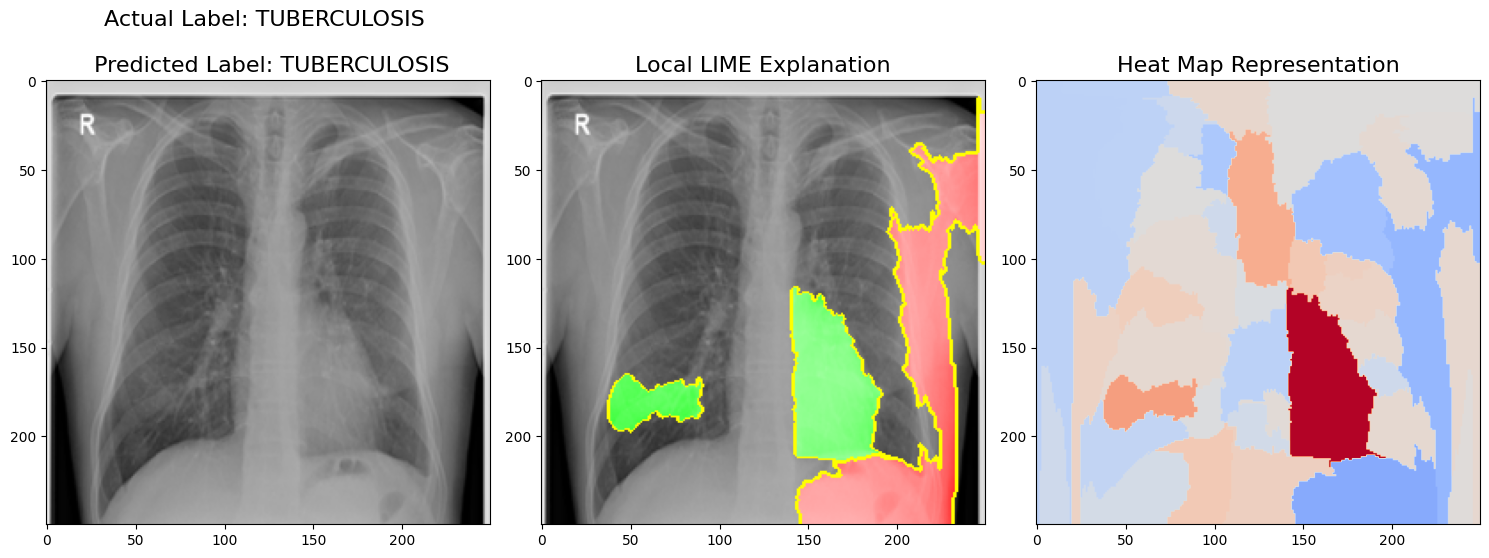

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

batch = np.random.randint(45,47)
# batch = 47
im = np.random.randint(0,16)
print(f"batch : {batch}, sample no: {im}")
# -------------------------------------------

actual_label = labels[np.argmax(test_dataset.__getitem__(idx=batch)[1][im])]
pred_label = labels[np.argmax(inv_model.predict(test_dataset.__getitem__(idx=batch)[0])[im])]

ax1.imshow(test_dataset.__getitem__(idx=batch)[0][im])
ax1.set_title(f"Actual Label: {actual_label} \n\n Predicted Label: {pred_label}", fontsize=16)

# ------------------------------------------------


explanation = explainer.explain_instance(test_dataset.__getitem__(idx=batch)[0][im].astype('double'), 
                                         inv_model.predict, 
                                         top_labels=4,
                                         hide_color=0,
                                        #  num_features=4, 
                                         num_samples=1000)

# ---------------------------------------------------


temp0, mask0 = explanation.get_image_and_mask(explanation.top_labels[np.argmax(inv_model.predict(test_dataset.__getitem__(idx=batch)[0])[im])], 
                                            positive_only=False, 
                                            num_features=4, 
                                            hide_rest=False)
ax2.imshow(mark_boundaries(temp0, mask0))
ax2.set_title(f"Local LIME Explanation", fontsize=16)

# ---------------------------------------------------

ind =  explanation.top_labels[np.argmax(inv_model.predict(test_dataset.__getitem__(idx=batch)[0])[im])]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
ax3.imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
ax3.set_title(f"Heat Map Representation", fontsize=16)


# plt.colorbar()
plt.tight_layout()
plt.show()